### Parse and plot BAS's BEDMAP1 data

Questions:

1. The file seems to have ~4 groupings of points into "Lines". Do these have any meaning, or should I just throw all points into the same geometry?
2. Are the points in order, or random? (Should I use a LineString or MultiPoint for each geometry?)

In [1]:
import numpy as np
import pyproj

import matplotlib.pyplot as plt

In [2]:
filepath = "/Users/lindzey/RadarData/ANTARCTIC/BAS/BAS_RESPAC_Radar.xyz"

In [3]:
seasons = {}
season = None
curr_line = None
with open(filepath, "r") as fp:
    for line in fp:
        if line.startswith('/'):
            continue
        if "Line" in line:
            season = line.split()[1]
            if curr_line is not None:
                seasons[season] = np.array(curr_line)
            curr_line = []
        else:
            tokens = line.split()
            
            current_record, season, lon, lat, xx, yy, wgs84_height, tice, srfelev, bedelev = tokens
            try:
                curr_line.append((float(lon), float(lat)))
            except Exception as ex:
                # Some records don't have position data; just skip them.
                continue
        
    

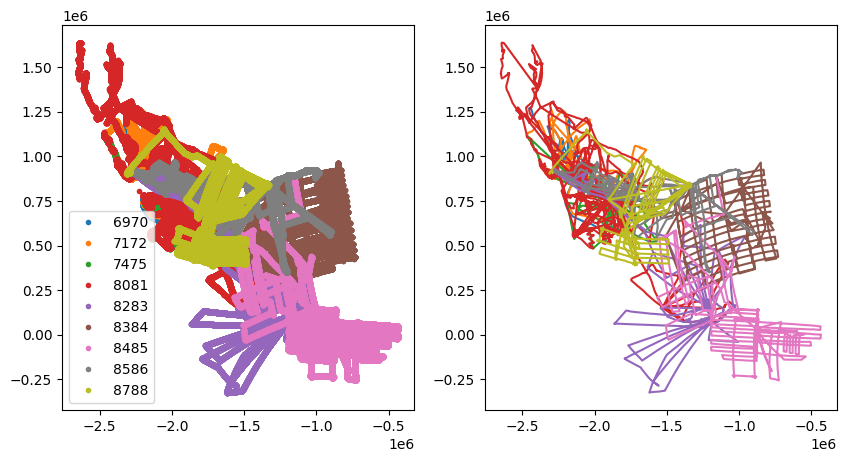

In [4]:
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)
ps71 = pyproj.Proj('epsg:3031')
for season, points in seasons.items():
    lon = points[:,0]
    lat = points[:,1]
    
    xx, yy = ps71.transform(lon, lat)
    ax1.plot(xx, yy, '.')
    ax2.plot(xx, yy, '-')
    ax1.legend(seasons.keys())

Hallelujah, it looks like they're even mostly in order, with a few exceptions, probably start/end of flights. So, create a list of segments within each flight?

In [5]:
seasons.keys()

dict_keys(['6970', '7172', '7475', '8081', '8283', '8384', '8485', '8586', '8788'])

(array([7.8400e+02, 6.9543e+04, 1.1579e+04, 3.3000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <BarContainer object of 10 artists>)

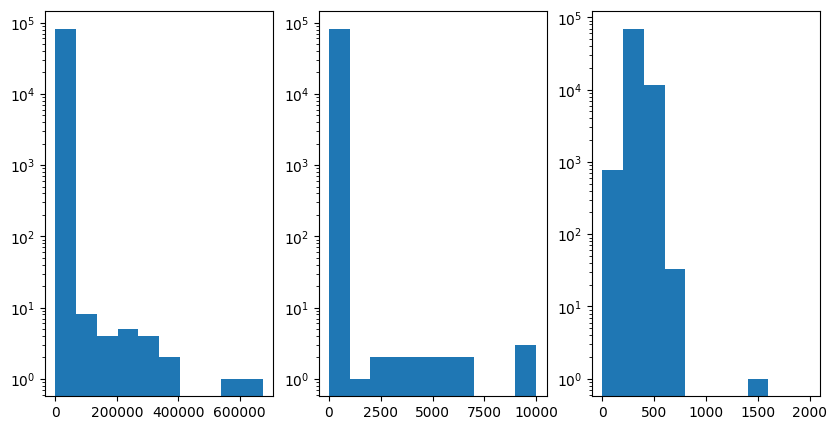

In [6]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2, ax3 = fig.subplots(1,3)

points = seasons['8081']
lon = points[:,0]
lat = points[:,1]
xx, yy = ps71.transform(lon, lat)
dx = xx[1:] - xx[0:-1]
dy = yy[1:] - yy[0:-1]
dists = np.sqrt(dx*dx + dy*dy)
dists = np.insert(dists, 0, 0)

ax1.hist(dists, log=True)
ax2.hist(dists, log=True, range=(0,10000))
ax3.hist(dists, log=True, range=(0,2000))

Given the above distribution, I'm going to call any skip of more than 1km a separate segment.

In [7]:
skips, = np.where(dists > 1000)
skips = np.insert(skips, 0, 0)
skips = np.append(skips, len(points))

In [8]:
len(skips), skips

(61,
 array([    0,   571,  1734,  1795,  1796,  3072,  3116,  4878,  4888,
         6939,  6940,  7476,  7477,  9949,  9981, 13221, 13231, 13258,
        15330, 15460, 21323, 23156, 23171, 25705, 26782, 29183, 31991,
        32925, 35919, 35920, 39542, 42962, 43562, 46408, 47067, 49572,
        50155, 52544, 56072, 56537, 60008, 60853, 62647, 63175, 63848,
        66893, 68847, 69273, 70640, 70654, 71845, 73671, 74160, 75042,
        75717, 75966, 76185, 76997, 80193, 80624, 81998]))

In [9]:
points[0:570,:], points[570:1733,:]

(array([[-68.299988, -71.333328],
        [-68.296303, -71.334473],
        [-68.293198, -71.335426],
        ...,
        [-72.357964, -72.955933],
        [-72.367432, -72.959488],
        [-72.377029, -72.963074]]),
 array([[-72.386658, -72.96666 ],
        [-72.420959, -72.987961],
        [-72.428177, -72.991211],
        ...,
        [-84.207581, -75.930252],
        [-84.218697, -75.932854],
        [-84.229843, -75.935501]]))

In [10]:
points.shape

(81998, 2)

In [11]:
segments = [points[skips[idx]:skips[idx+1],:] for idx in range(len(skips)-1)]

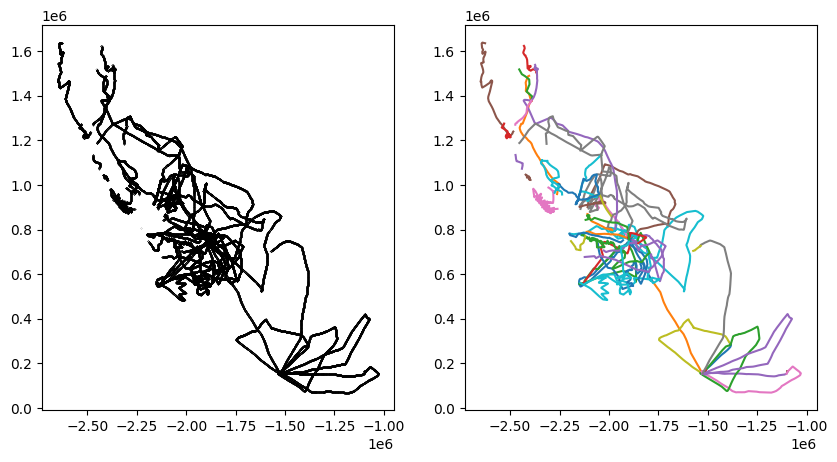

In [12]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.subplots(1,2)

points = seasons['8081']
lon = points[:,0]
lat = points[:,1]
xx, yy = ps71.transform(lon, lat)
ax1.plot(xx,yy,'k.', markersize=0.2)

for segment in segments:
    lon = segment[:,0]
    lat = segment[:,1]
    xx, yy = ps71.transform(lon, lat)
    ax2.plot(xx,yy,'-')

OK, that looks reasonable for splitting the points into groupings that can be plotted using line segments.

BAS_1969_1970
Has 20 segments
BAS_1971_1972
Has 21 segments
BAS_1974_1975
Has 12 segments
BAS_1980_1981
Has 59 segments
BAS_1982_1983
Has 10 segments
BAS_1983_1984
Has 86 segments
BAS_1984_1985
Has 86 segments
BAS_1985_1986
Has 29 segments
BAS_1987_1988
Has 26 segments


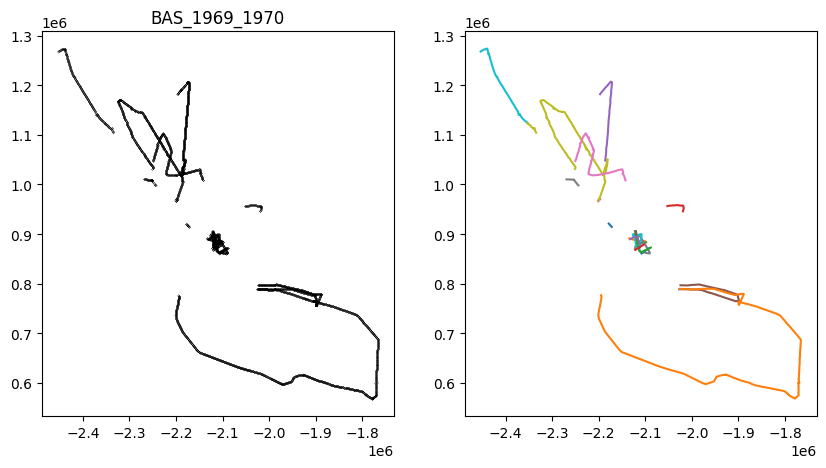

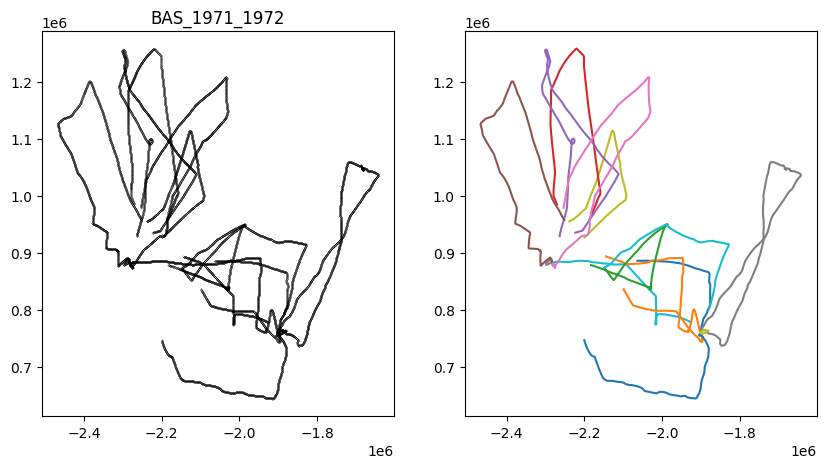

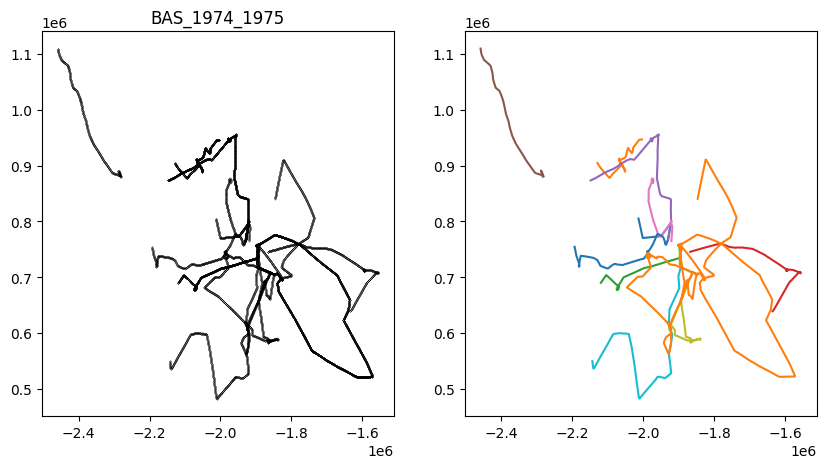

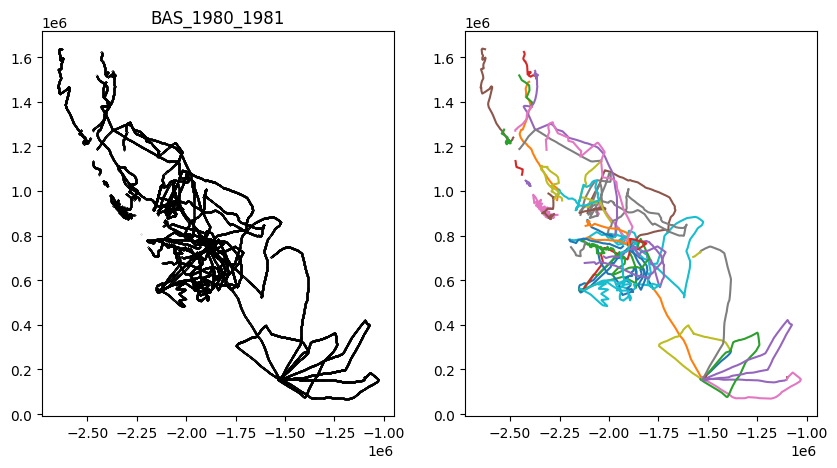

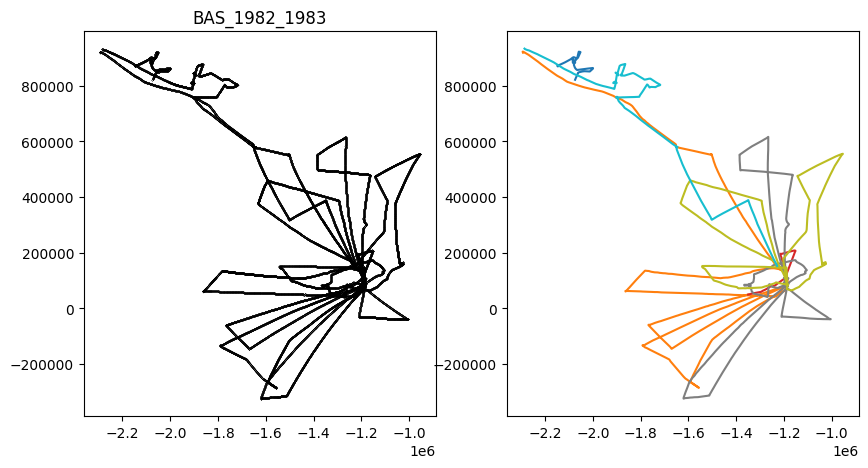

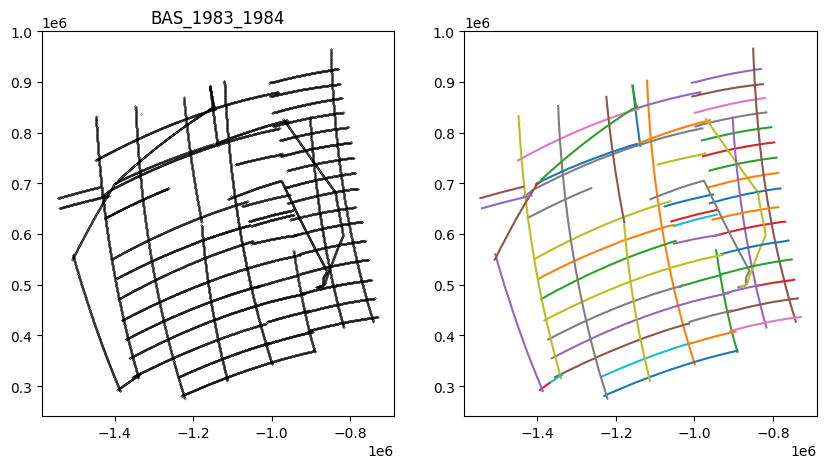

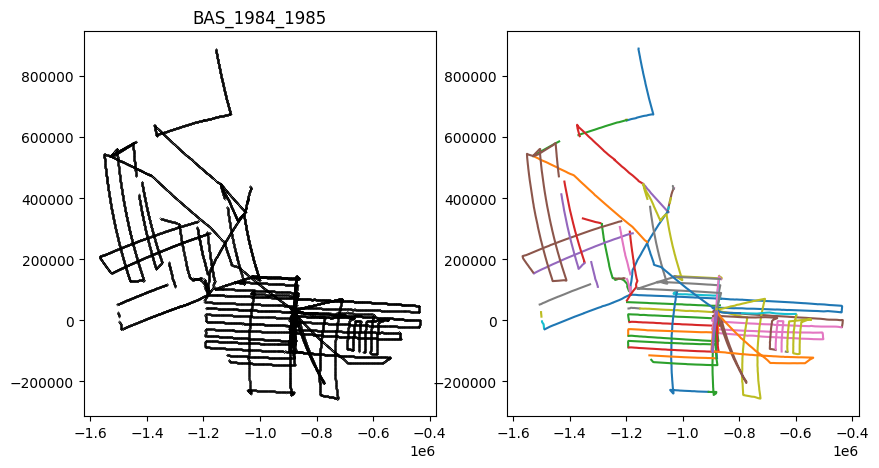

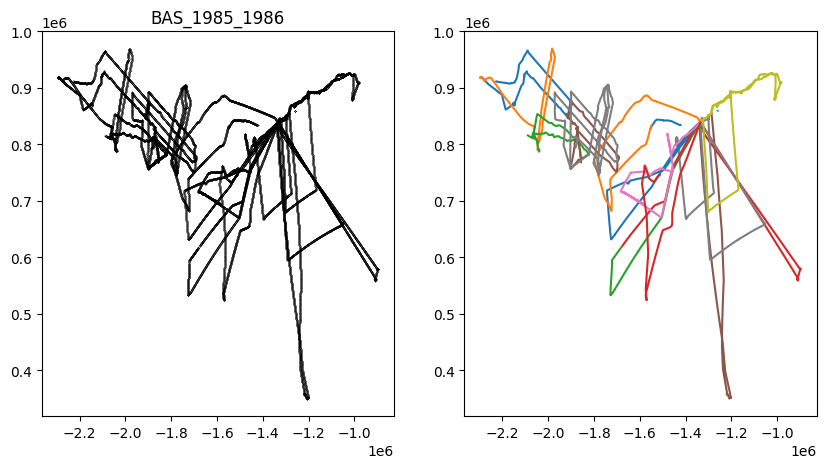

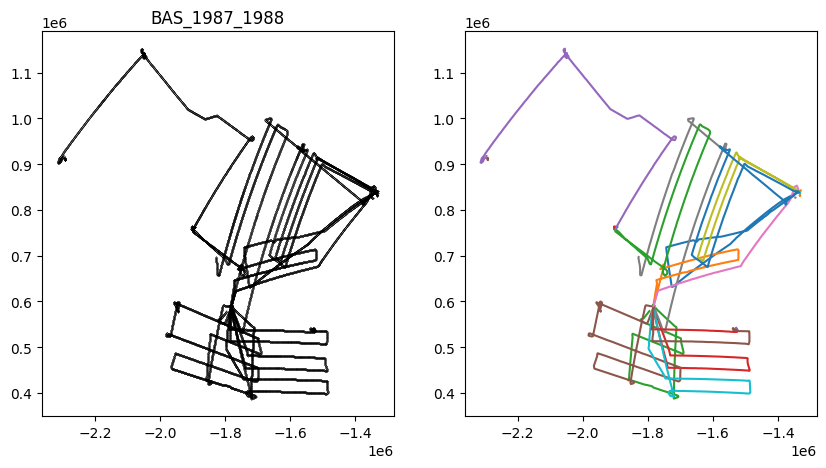

In [13]:
for season, points in seasons.items():
    season_name = "BAS_19{}_19{}".format(season[0:2], season[2:4])
    print(season_name)
    
    ## break each season into segments that can be plotted with line segments
    # Find distance between consecutive points
    lon = points[:,0]
    lat = points[:,1]
    xx, yy = ps71.transform(lon, lat)
    dx = xx[1:] - xx[0:-1]
    dy = yy[1:] - yy[0:-1]
    dists = np.sqrt(dx*dx + dy*dy)
    dists = np.insert(dists, 0, 0)
    # Find indices of larger jumps
    skips, = np.where(dists > 2000)
    skips = np.insert(skips, 0, 0)
    skips = np.append(skips, len(points))
    # 
    segments = [points[skips[idx]:skips[idx+1],:] for idx in range(len(skips)-1)]
    print("Has {} segments".format(len(segments)))
    
    fig = plt.figure(figsize=(10, 5))
    ax1, ax2 = fig.subplots(1,2)
    ax1.plot(xx,yy,'k.', markersize=0.2)
    ax1.set_title(season_name)

    for segment in segments:
        if len(segment) < 1:
            continue
        lon = segment[:,0]
        lat = segment[:,1]
        xx, yy = ps71.transform(lon, lat)
        ax2.plot(xx,yy,'-')